In [1]:
import pandas as pd
import numpy as np
from datetime import date
import missingno as msn
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import country_converter as coco
import os

# Set the global font to be Times New Roman
import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['font.size'] = 8 
colors = sns.color_palette()
colors

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

### Data Cleaning
---

In [2]:
df = pd.read_csv("private_folder/data/new_data.csv", low_memory=False)

col_names = ['country_name', 'country_code', 'time', 'time_code', 'adj_net_national_income_growth', 'adj_net_national_income_percap_growth', 'adj_net_saving_exl_gini', 'adj_net_saving_gross_gini', 'bank_capital_assets_ratio', 'bank_npl_ratio', 'brith_rate', 'bound_rate_all', 'bound_rate_manufacturing', 'bribery_incidence', 'broad_money_gdp', 'broad_money_growth', 'central_gov_debt_gdp', 'co2_emission', 'co2_intensity', 'cpi', 'current_account_balance_gdp', 'employment_population', 'export_value', 'export_volumne', 'export_goods_ser_gdp', 'export_goods_ser_growth', 'fdi_in_gdp', 'fdi_out_gdp', 'gdp', 'gdp_deflator', 'gdp_growth', 'gdp_percap', 'gdp_percap_growth', 'gini_index', 'gini_growth', 'gini_percap', 'gini_percap_growth', 'gross_capital_forma_gdp', 'gross_capital_forma_growth', 'gross_national_expen_gdp', 'gross_saving_gdp', 'hci', 'import_goods_ser_gdp', 'import_goods_ser_growth', 'industry_value_add_gdp', 'industry_value_add_growth', 'inflation_cpi', 'inflation_deflator', 'interests_expense', 'interests_revenue', 'interest_spread', 'labor_partici_15', 'labor_partici_15_64', 'femal_labor_total', 'lending_rate', 'net_lending_borrowing_gdp', '15_64_pop_total', '15_64_pop_femal', '15_64_pop_male', 'pop_growth', 'pop_density', 'femal_pop_total', 'tariff_all', 'tariff_manufacturing', 'tariff_primary', 'tax_rev_gdp', 'trade_gdp', 'unemployment_female', 'umemployment_male', 'umempoyment_total', 'population_total']

# Rename the columns
df.columns = col_names
# sort the data
df = df.sort_values(by=['country_name', 'time'])

# choose only OECD countries
oecd_countries_iso3 = [
    "AUS", "AUT", "BEL", "CAN", "CHL", "COL", "CRI", "CZE", "DNK", "EST", 
    "FIN", "FRA", "DEU", "GRC", "HUN", "ISL", "IRL", "ISR", "ITA", "JPN", 
    "KOR", "LVA", "LTU", "LUX", "MEX", "NLD", "NZL", "NOR", "POL", "PRT", 
    "SVK", "SVN", "ESP", "SWE", "CHE", "TUR", "GBR", "USA"
]

g10_countries_iso3 = ['BEL', 'CAN', 'FRA', 'DEU', 'ITA', 'JPN', 'NLD', 'SWE', 'CHE', 'GBR', 'USA']

g20_iso3_codes = [ "ARG", "AUS", "BRA", "CAN", "CHN", "FRA", "DEU", "IND", "IDN", "ITA", "JPN", "KOR", "MEX", "RUS", "SAU", "ZAF", "TUR", "GBR", "USA"]

In [3]:
# choose only OECD countries
df_oecd = df[df['country_code'].isin(oecd_countries_iso3)].copy()

# convert date to datetime
df_oecd['time'] = pd.to_datetime(df_oecd['time'], format='%Y').dt.year

# replace '..' with np.nan
df_oecd = df_oecd.replace('..', np.nan)

# drop columns
df_oecd = df_oecd.drop(columns=['time_code'])

# choose time period 1992 - 2022
df_oecd = df_oecd[(df_oecd['time'] >= 1995) & (df_oecd['time'] <= 2022)]

cols = ['gdp', 'gdp_percap', 'trade_gdp', 'import_goods_ser_gdp', 'export_goods_ser_gdp', 'cpi', 'gdp_deflator', 'inflation_cpi', 'inflation_deflator', 'gross_capital_forma_gdp', 'gross_national_expen_gdp', 'industry_value_add_gdp', 'umempoyment_total', 'brith_rate', 'employment_population', '15_64_pop_total', 'pop_growth', 'population_total', 'fdi_in_gdp']

# convert to float
df_oecd[cols] = df_oecd[cols].astype(float)

# gen log gdp, log gdp_percap
df_oecd['log_gdp'] = np.log(df_oecd['gdp'])
df_oecd['log_gdp_percap'] = np.log(df_oecd['gdp_percap'])
df_oecd['log_population_total'] = np.log(df_oecd['population_total'])
# set cpi to 100 in the first year for each country
df_oecd['cpi'] = df_oecd.groupby('country_name')['cpi'].transform(lambda x: x / x.iloc[0] * 100)

# select the columns
select_cols = ['log_gdp', 'log_gdp_percap', 'trade_gdp', 'import_goods_ser_gdp', 'export_goods_ser_gdp', 'cpi', 'gdp_deflator', 'inflation_cpi', 'inflation_deflator', 'gross_capital_forma_gdp', 'gross_national_expen_gdp', 'umempoyment_total', 'brith_rate', 'employment_population', '15_64_pop_total', 'pop_growth', 'log_population_total', 'fdi_in_gdp']
df_oecd = df_oecd[['country_name', 'country_code', 'time'] + select_cols]

In [4]:
df_oecd[['country_name', 'time', 'fdi_in_gdp']].query('country_name == "Luxembourg"').head(10)

,country_name,time,fdi_in_gdp
7459,Luxembourg,1995,NaN
7460,Luxembourg,1996,NaN
7461,Luxembourg,1997,NaN
7462,Luxembourg,1998,NaN
7463,Luxembourg,1999,NaN
7464,Luxembourg,2000,NaN
7465,Luxembourg,2001,NaN
7466,Luxembourg,2002,17.941667
7467,Luxembourg,2003,14.464108
7468,Luxembourg,2004,14.771614


In [5]:
# if country has missing value in fdi_net_flow, drop the country
df_oecd = df_oecd.groupby('country_name').filter(lambda x: x['fdi_in_gdp'].notna().all())

# add the treated column
df_oecd['tr_group'] = np.where(df_oecd['country_code'] == 'GBR', 1, 0)
# add post period column
df_oecd['post_period'] = np.where(df_oecd['time'] >= 2017, 1, 0)
# add treated post column
df_oecd['treated'] = df_oecd['tr_group'] * df_oecd['post_period']

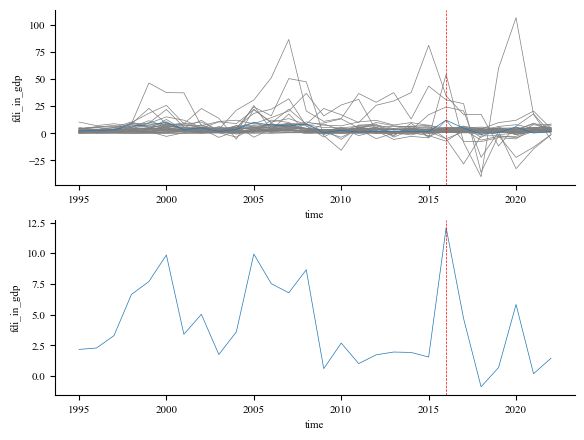

In [6]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df_oecd.query("tr_group==0"), x='time', y='fdi_in_gdp', ax=ax[0], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df_oecd.query("tr_group==1"), x='time', y='fdi_in_gdp', ax=ax[0], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[0].axvline(2016, color='red', linestyle='--', linewidth=0.5)
sns.lineplot(data=df_oecd.query("tr_group==1"), x='time', y='fdi_in_gdp', ax=ax[1], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[1].axvline(2016, color='red', linestyle='--', linewidth=0.5)

sns.despine()

<Axes: >

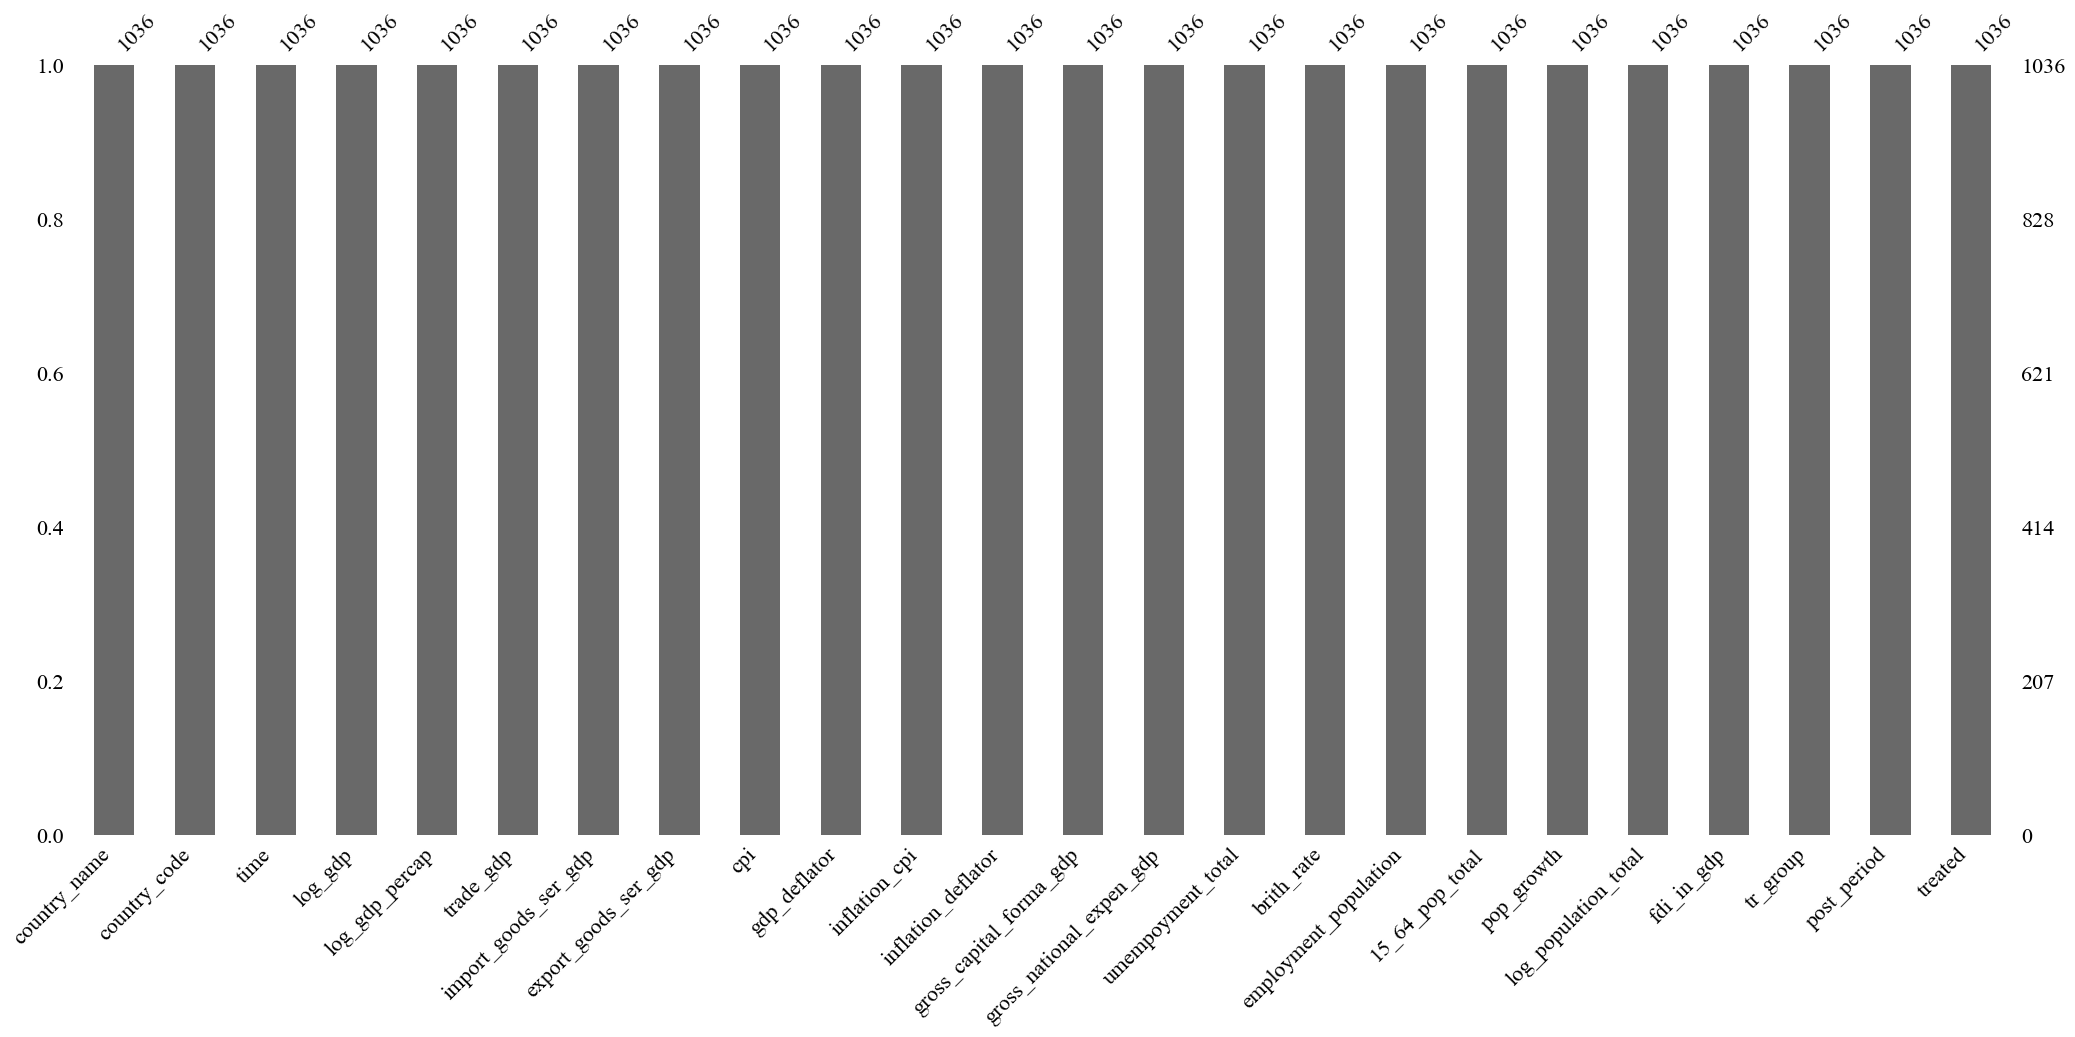

In [7]:
msn.bar(df_oecd)

In [8]:
# Define the range condition
def check_fdi_in_gdp_outside_range(group):
    return (group['fdi_in_gdp'] < -25) | (group['fdi_in_gdp'] > 25)

# Group by 'country' and check if any value is outside the range
countries_with_out_of_range_values = df_oecd.groupby('country_name').apply(lambda x: check_fdi_in_gdp_outside_range(x).any())

# List of countries to drop
countries_to_drop = countries_with_out_of_range_values[countries_with_out_of_range_values].index

# Drop these countries from the DataFrame
df_drop_extrem = df_oecd[~df_oecd['country_name'].isin(countries_to_drop)].copy()

C:\Users\c.wang\AppData\Local\Temp\ipykernel_4368\1295211793.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  countries_with_out_of_range_values = df_oecd.groupby('country_name').apply(lambda x: check_fdi_in_gdp_outside_range(x).any())


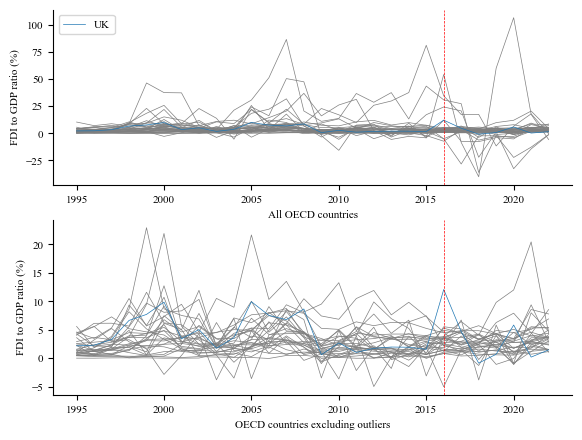

In [9]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df_oecd.query("tr_group==0"), x='time', y='fdi_in_gdp', ax=ax[0], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df_oecd.query("tr_group==1"), x='time', y='fdi_in_gdp', ax=ax[0], units='country_code', estimator=None, color=colors[0], linewidth=0.5, label='UK')
ax[0].axvline(2016, color='red', linestyle='--', linewidth=0.5)
ax[0].set(ylabel='FDI to GDP ratio (%)', xlabel='All OECD countries')

sns.lineplot(data=df_drop_extrem.query("tr_group==0"), x='time', y='fdi_in_gdp', ax=ax[1], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df_drop_extrem.query("tr_group==1"), x='time', y='fdi_in_gdp', ax=ax[1], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[1].axvline(2016, color='red', linestyle='--', linewidth=0.5)
ax[1].set(ylabel='FDI to GDP ratio (%)', xlabel='OECD countries excluding outliers')

sns.despine()
# Save the figure
plt.savefig('figs/fdi_oecd.png', dpi=300)

In [10]:
print(countries_to_drop)

Index(['Austria', 'Belgium', 'Hungary', 'Iceland', 'Ireland', 'Netherlands',
       'Switzerland'],
      dtype='object', name='country_name')


In [11]:
df_drop_extrem.country_name.nunique()

30

### 1. Estimate the treatment effect using the CSC-IPCA model
---

In [12]:
from src.csc_ipca import CSC_IPCA
from src.csc_ife import CSC_IFE
from src.scm import SCM

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

In [13]:
# gen a list of covariates
covariates = ['log_gdp', 'log_gdp_percap', 'import_goods_ser_gdp', 'export_goods_ser_gdp', 'gdp_deflator', 'gross_capital_forma_gdp', 'umempoyment_total', 'employment_population', 'log_population_total']
#covariates = ['log_gdp', 'import_goods_ser_gdp', 'export_goods_ser_gdp', 'gdp_deflator', 'gross_capital_forma_gdp', 'employment_population', 'log_population_total']

valitile_country = []
df_finale = df_drop_extrem[~df_drop_extrem.country_name.isin(valitile_country)].copy()

# instantiate the model
model = CSC_IPCA()
# set the number of principal components
K = 2

# fit the model
model.fit(df_finale, 'country_name', 'time', 'fdi_in_gdp', 'treated', covariates, K, verbose=True)
results = df_finale.query("country_name=='United Kingdom'")[['time', 'fdi_in_gdp']]
results['Y_syn'] = model.predict().flatten()
results['residual'] = results['fdi_in_gdp'] - results['Y_syn']    

iter 0: tol_Gama: 0.049502480303682275, tol_F: 8.09596009027101
iter 1: tol_Gama: 0.02273417447006223, tol_F: 3.4796043677061483
iter 2: tol_Gama: 0.011999848022467067, tol_F: 1.6057897140980621
iter 3: tol_Gama: 0.005658342418881038, tol_F: 1.013999664780231
iter 4: tol_Gama: 0.002614322630950362, tol_F: 0.5999127319773843
iter 5: tol_Gama: 0.0012092790034515305, tol_F: 0.34265225786557174
iter 6: tol_Gama: 0.0005845597851985946, tol_F: 0.2141868472037487
iter 7: tol_Gama: 0.0003061237425551998, tol_F: 0.1556870819987104
iter 8: tol_Gama: 0.00017681431373560864, tol_F: 0.11611796549387421
iter 9: tol_Gama: 0.00011703791926681757, tol_F: 0.08771095823181696
iter 10: tol_Gama: 8.759160861075265e-05, tol_F: 0.0666712228472619
iter 11: tol_Gama: 6.635416132819323e-05, tol_F: 0.05084218538150509
iter 12: tol_Gama: 5.05778455863852e-05, tol_F: 0.03883920276051356
iter 13: tol_Gama: 3.867138624612677e-05, tol_F: 0.02970017856889129
iter 14: tol_Gama: 2.961204369668173e-05, tol_F: 0.022726136

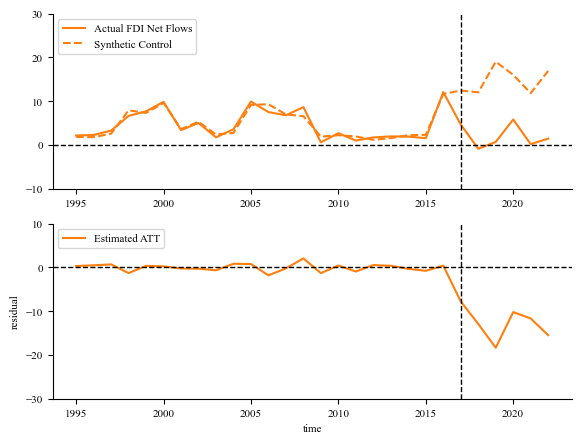

In [14]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

ax1.plot(df_finale.query("tr_group==1").groupby('time').fdi_in_gdp.mean(), color=colors[1], label='Actual FDI Net Flows')
ax1.plot(df_finale.time.unique(), results.Y_syn, color=colors[1], label='Synthetic Control', linestyle='--')
ax1.axvline(x=df_finale.query("post_period==0").time.max() + 1, color='black', linestyle='--', linewidth=1)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.legend(loc='upper left')
ax1.set(ylim=(-10, 30))

# plot the estimated treatment effect
sns.lineplot(data=results, x='time', y='residual', ax=ax2, color=colors[1], label='Estimated ATT')

ax2.axvline(x=df_finale.query("post_period==0").time.max() + 1, color='black', linestyle='--', linewidth=1)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.legend(loc='upper left')
ax2.set(ylim=(-30, 10))

sns.despine()

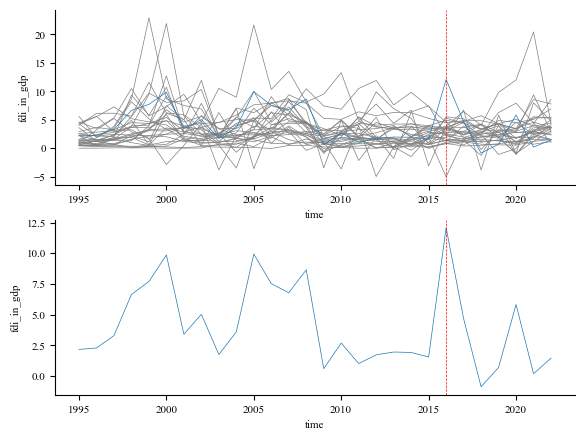

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df_finale.query("tr_group==0"), x='time', y='fdi_in_gdp', ax=ax[0], units='country_code', estimator=None, color=colors[7], linewidth=0.5)
sns.lineplot(data=df_finale.query("tr_group==1"), x='time', y='fdi_in_gdp', ax=ax[0], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[0].axvline(2016, color='red', linestyle='--', linewidth=0.5)
sns.lineplot(data=df_finale.query("tr_group==1"), x='time', y='fdi_in_gdp', ax=ax[1], units='country_code', estimator=None, color=colors[0], linewidth=0.5)
ax[1].axvline(2016, color='red', linestyle='--', linewidth=0.5)

sns.despine()

In [16]:
# specify the null hypothesis
nulls = np.linspace(-60, 60, 100)
# estimate the confidence interval use the function class
ci_test = model.inference(nulls, alpha=0.1, n_jobs=-1, verbose=True)

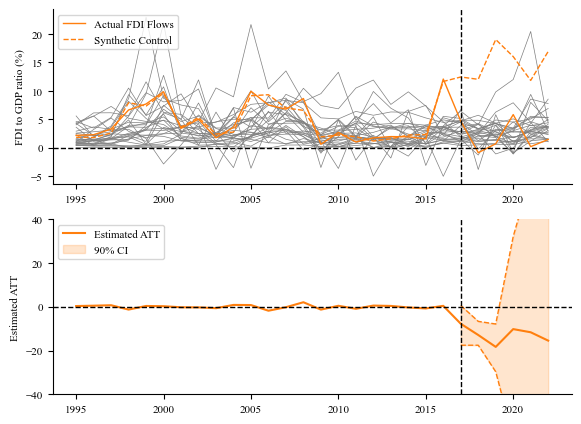

In [19]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=df_finale.query("tr_group==0"), x='time', y='fdi_in_gdp', units='country_name', estimator=None, ax=ax1, legend=False, color=colors[7], linewidth=0.5)
ax1.plot(df_finale.query("tr_group==1").groupby('time').fdi_in_gdp.mean(), color=colors[1], label='Actual FDI Flows', linewidth=1)

ax1.plot(df_finale.time.unique(), results.Y_syn, color=colors[1], label='Synthetic Control', linestyle='--', linewidth=1)
ax1.axvline(x=df_finale.query("post_period==0").time.max()+1, color='black', linestyle='--', linewidth=1)
ax1.axhline(0, color='black', linestyle='--', linewidth=1)
ax1.set(ylabel='FDI to GDP ratio (%)', xlabel='')
ax1.legend(loc='upper left')

# plot the estimated treatment effect
sns.lineplot(data=results, x='time', y='residual', ax=ax2, color=colors[1], label='Estimated ATT')
ax2.fill_between(ci_test.index, ci_test["90_ci_lower"], ci_test["90_ci_upper"], 
                 alpha=0.2, color="C1", label='90% CI')

# Plotting the upper and lower edges with dotted lines
ax2.plot(ci_test.index, ci_test["90_ci_lower"], linestyle='--', color='C1', linewidth=1)
ax2.plot(ci_test.index, ci_test["90_ci_upper"], linestyle='--', color='C1', linewidth=1)
ax2.axvline(x=df_finale.query("post_period==0").time.max()+1, color='black', linestyle='--', linewidth=1)
ax2.axhline(0, color='black', linestyle='--', linewidth=1)
ax2.set(ylim=(-40, 40), ylabel='Estimated ATT', xlabel='')
ax2.legend(loc='upper left')

sns.despine()
# save the figure
plt.savefig('figs/ukfdi_ipca.png', dpi=300)

In [20]:
results2 = pd.DataFrame()
results2['time'] = results.time.values
results2['factor1'] = model.F[0]
results2['factor2'] = model.F[1]
results2['loading1'] = (df_finale.query('tr_group == 1')[covariates] @ model.Gama)[0].values
results2['loading2'] = (df_finale.query('tr_group == 1')[covariates] @ model.Gama)[1].values

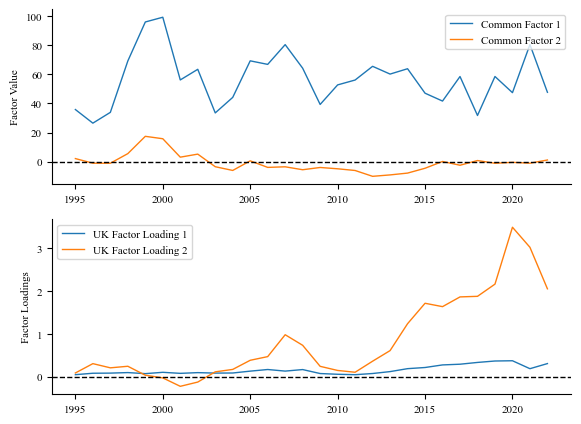

In [23]:
fig, ax = plt.subplots(2, 1, figsize=(6.7, 5))

sns.lineplot(data=results2, x='time', y='factor1', ax=ax[0], label='Common Factor 1', linewidth=1)
sns.lineplot(data=results2, x='time', y='factor2', ax=ax[0], label='Common Factor 2', linewidth=1)
ax[0].axhline(0, color='black', linestyle='--', linewidth=1)
ax[0].set(ylabel='Factor Value', xlabel='')

sns.lineplot(data=results2, x='time', y='loading1', ax=ax[1], label='UK Factor Loading 1', linewidth=1)
sns.lineplot(data=results2, x='time', y='loading2', ax=ax[1], label='UK Factor Loading 2', linewidth=1)
ax[1].axhline(0, color='black', linestyle='--', linewidth=1)
ax[1].set(ylabel='Factor Loadings', xlabel='')

sns.despine()
# save the figure
plt.savefig('figs/factors_ipca.png', dpi=300)

In [24]:
model.Gama.T @ model.Gama

array([[1.00000000e+00, 4.42060369e-17],
       [4.42060369e-17, 1.00000000e+00]])

In [25]:
model.F @ model.F.T

array([[ 9.94545630e+04, -1.21277029e-12],
       [-1.21277029e-12,  1.08611332e+03]])

In [26]:
results2['us_loading1'] = (df_finale.query("country_name == 'United States'")[covariates] @ model.Gama)[0].values
results2['us_loading2'] = (df_finale.query("country_name == 'United States'")[covariates] @ model.Gama)[1].values

results2['jp_loading1'] = (df_finale.query("country_name == 'Japan'")[covariates] @ model.Gama)[0].values
results2['jp_loading2'] = (df_finale.query("country_name == 'Japan'")[covariates] @ model.Gama)[1].values

results2['de_loading1'] = (df_finale.query("country_name == 'Germany'")[covariates] @ model.Gama)[0].values
results2['de_loading2'] = (df_finale.query("country_name == 'Germany'")[covariates] @ model.Gama)[1].values

results2['fr_loading1'] = (df_finale.query("country_name == 'France'")[covariates] @ model.Gama)[0].values
results2['fr_loading2'] = (df_finale.query("country_name == 'France'")[covariates] @ model.Gama)[1].values

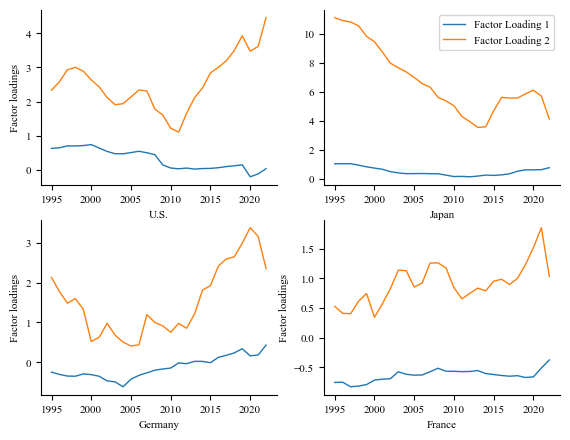

In [28]:
fig, ax = plt.subplots(2, 2, figsize=(6.7, 5))

sns.lineplot(data=results2, x='time', y='us_loading1', ax=ax[0, 0], linewidth=1)
sns.lineplot(data=results2, x='time', y='us_loading2', ax=ax[0, 0], linewidth=1)
ax[0, 0].set(ylabel='Factor loadings', xlabel='U.S.')

sns.lineplot(data=results2, x='time', y='jp_loading1', ax=ax[0, 1], label='Factor Loading 1', linewidth=1)
sns.lineplot(data=results2, x='time', y='jp_loading2', ax=ax[0, 1], label='Factor Loading 2', linewidth=1)
ax[0, 1].set(ylabel='', xlabel='Japan')

sns.lineplot(data=results2, x='time', y='de_loading1', ax=ax[1, 0], linewidth=1)
sns.lineplot(data=results2, x='time', y='de_loading2', ax=ax[1, 0], linewidth=1)
ax[1, 0].set(ylabel='Factor loadings', xlabel='Germany')

sns.lineplot(data=results2, x='time', y='fr_loading1', ax=ax[1, 1], linewidth=1)
sns.lineplot(data=results2, x='time', y='fr_loading2', ax=ax[1, 1], linewidth=1)
ax[1, 1].set(ylabel='Factor loadings', xlabel='France')

sns.despine()
# save the fig
plt.savefig('figs/loadings_ipca.png', dpi=300)

Appendix
---

In [63]:
formula1 = "fdi_in_gdp ~ " + " + ".join(covariates)
model1 = sm.OLS.from_formula(formula=formula1, data=df_finale)
fit1 = model1.fit()

formula2 = "fdi_in_gdp ~ " + " + ".join(covariates) + " + C(time)"
model2 = sm.OLS.from_formula(formula=formula2, data=df_finale)
fit2 = model2.fit()

formula3 = "fdi_in_gdp ~ " + " + ".join(covariates) + " + C(country_name)"
model3 = sm.OLS.from_formula(formula=formula3, data=df_finale)
fit3 = model3.fit()

formula4 = "fdi_in_gdp ~ " + " + ".join(covariates) + " + C(time) + C(country_name)"
model4 = sm.OLS.from_formula(formula=formula4, data=df_finale)
fit4 = model4.fit()

summary_table = summary_col([fit1, fit2, fit3, fit4], stars=True, model_names=['Model 1', 'Model 2', 'Model 3', 'Model 4'])
summary_df = summary_table.tables[0]

summary_df = summary_df.iloc[-22:, :]
# Save the table
#summary_df.to_latex('figs/regression_table.tex')

In [66]:
print(summary_df.to_latex())

\begin{tabular}{lllll}
\toprule
 & Model 1 & Model 2 & Model 3 & Model 4 \\
\midrule
Intercept & 4.2650 & 4.2272 & -30.9338 & -51.1866 \\
 & (3.4547) & (3.3835) & (24.0543) & (35.8816) \\
R-squared & 0.1242 & 0.2245 & 0.3485 & 0.4328 \\
R-squared Adj. & 0.1158 & 0.1907 & 0.3184 & 0.3860 \\
employment_population & 0.0967*** & 0.1054*** & 0.0425 & 0.0604 \\
 & (0.0259) & (0.0250) & (0.0639) & (0.0622) \\
export_goods_ser_gdp & 0.0179 & 0.0304 & 0.1389*** & 0.0850** \\
 & (0.0221) & (0.0214) & (0.0397) & (0.0387) \\
gdp_deflator & -0.0056* & -0.0067* & -0.0067* & -0.0039 \\
 & (0.0030) & (0.0036) & (0.0039) & (0.0039) \\
gross_capital_forma_gdp & 0.0646** & 0.0368 & 0.2544*** & 0.1152** \\
 & (0.0250) & (0.0257) & (0.0456) & (0.0491) \\
import_goods_ser_gdp & 0.0076 & -0.0088 & -0.1233*** & -0.0801* \\
 & (0.0243) & (0.0238) & (0.0409) & (0.0418) \\
log_gdp & -0.2595*** & -0.2938*** & 0.4932 & 1.0023 \\
 & (0.0692) & (0.0674) & (0.5019) & (0.7904) \\
log_gdp_percap & -0.2978** & -0.3432**

In [57]:
dat = df_finale[['country_name', 'time', 'treated'] + covariates + ['fdi_in_gdp']].copy()

col_names = ['Country', 'Year', 'Treated', 'Log GDP', 'Log GDP per Capita', 'Import to GDP', 'Export to GDP', 'GDP Deflator', 'Gross Capital Formation to GDP', 'Unemployment Rate', 'Employment to Population', 'Log Population', 'FDI to GDP']
dat.columns = col_names

varibles = ['Log GDP', 'Log GDP per Capita', 'Import to GDP', 'Export to GDP', 'GDP Deflator', 'Gross Capital Formation to GDP', 'Unemployment Rate', 'Employment to Population', 'Log Population', 'FDI to GDP']
dat[varibles].describe().T

,count,mean,std,min,25%,50%,75%,max
Log GDP,840.0,26.649046,1.643143,23.050936,25.770268,26.463821,27.886680,30.686734
Log GDP per Capita,840.0,10.012319,0.706352,8.282415,9.462459,10.141566,10.597898,11.282690
Import to GDP,840.0,37.604257,17.084403,7.573635,27.068711,32.723376,44.083483,104.650716
Export to GDP,840.0,37.597389,17.775624,8.816470,25.777724,34.202989,44.720956,99.297404
GDP Deflator,840.0,87.525207,34.039625,1.291932,73.147587,89.950681,100.412896,707.412914
Gross Capital Formation to GDP,840.0,23.598851,4.374068,11.892284,20.860064,23.078132,25.784012,41.559704
Unemployment Rate,840.0,8.233505,4.244224,2.015000,5.112750,7.406000,10.281250,27.686000
Employment to Population,840.0,55.291267,5.802454,37.381000,51.558250,56.390500,59.487250,68.961000
Log Population,840.0,16.636727,1.397639,14.089001,15.486927,16.354140,17.879472,19.624468
FDI to GDP,840.0,3.113564,2.897323,-5.032550,1.298849,2.526383,4.322812,22.953964


In [ ]:
# save the summary table
#dat[varibles].describe().T.to_latex('figs/summary_table.tex', float_format="%.2f")